In [1]:
# Improve by ChatGPT & GitHub Copilot
# Running the requierements.ipynb
%run /bettik/PROJECTS/pr-data-ocean/riverama/Notebooks/requierements.ipynb

# Running functions_IT.ipynb
%run /bettik/PROJECTS/pr-data-ocean/riverama/Notebooks/OSSE_borrador/IT_modes/functions_IT_modes_v1.ipynb

In [2]:
it_modes = xr.open_mfdataset("/bettik/PROJECTS/pr-data-ocean/riverama/Datos/Filtrage/ssh_it_modes/Hourly/ssh_it_*.nc",combine='nested',concat_dim='time_counter',parallel=True)

In [5]:
date_range = it_modes.sel(time_counter=slice('2014-05-01T00:30:00', '2014-05-31T23:30:00')).load()

In [6]:
# Select the specific variable `ssh_it_mode_1`
it_mode_1 = date_range['ssh_it_mode_1']

# 3. Intelligent Rechunking
# Adjust the chunk size for 'time_counter' and keep the spatial dimensions intact
mode_1_rechunked = it_mode_1.chunk({'time_counter': len(it_mode_1.time_counter), 'nav_lat': 'auto', 'nav_lon': 'auto'})

# 4. Compute the power spectrum
# This step remains resource-intensive and might benefit from Dask optimization settings
spectrum = xrft.power_spectrum(mode_1_rechunked, dim=['time_counter'], detrend='constant', window=True, chunks_to_segments=True).compute()

# 5. Spatially average the spectrum and filter frequencies
mean_spectrum = spectrum.mean(dim=['nav_lat', 'nav_lon']).where(spectrum.freq_time_counter > 0, drop=True)

# 6. Convert frequencies to periods (days)
periods = 1 / (mean_spectrum.freq_time_counter * 86400)

/home/riverama/.conda/envs/env-stage/lib/python3.11/site-packages/xrft/xrft.py:47: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(


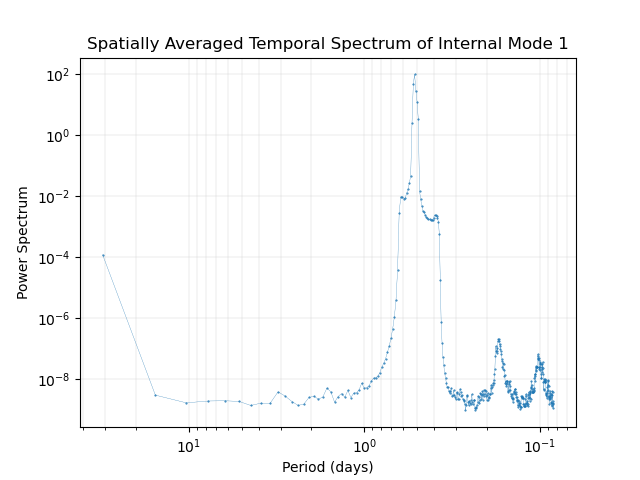

In [7]:
# Plotting
# Squeeze any singleton dimensions from 'mean_spectrum'
mean_spectrum_squeezed = mean_spectrum.squeeze()

plt.figure()
#plt.loglog(periods.freq_time_counter, mean_spectrum)
#plt.semilogy(periods, mean_spectrum, marker='.', markersize=3, linestyle='-', linewidth=0.1)
plt.loglog(periods, mean_spectrum_squeezed, marker='.', markersize=1, linestyle='-', linewidth=0.2)
plt.xlabel('Period (days)')
plt.ylabel('Power Spectrum')
plt.title('Spatially Averaged Temporal Spectrum of Internal Mode 1')

# Invert the x-axis by setting the xlim with reversed limits
plt.xlim(plt.xlim()[::-1])

plt.grid(True, which="both", ls="-", linewidth="0.3", color="lightgrey")
plt.show()